<center>
  <h1><b>PGM Project : Capturing label characteristics in VAEs</b></h1>
  <br>
  22 / 12 / 2023
  <br>
  <br>
  <b>Students name:</b>  Biel & David & Aissa
</center>


# Set Up

Import all the necessary libraries and modules that the notebook will use.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, random_split,Dataset
from torchvision import  transforms, utils
from torchvision.datasets import MNIST
from torchvision.utils import make_grid, save_image
from torchvision.transforms.functional import to_pil_image
import torchvision.utils as vutils
from torch.distributions import Normal
import torch.distributions as dist
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive
import zipfile
import os

This cell is used to mount Google Drive to the Colab environment. Mounting Google Drive allows the notebook to access and store files directly from/to Google Drive.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset

This cell prepares the celeba data loaders for model training and evaluation.

In [ ]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(64),
])


full_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)

# Define the sizes for train, validation, and test sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Define data loaders for train, validation, and test sets
batch_size = 32
train_loader_mnist = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader_mnist = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Visualizing Mnist-Fashion

Display a batch of images from the training set to visualize what the Mnist-Fashion dataset looks like after preprocessing.

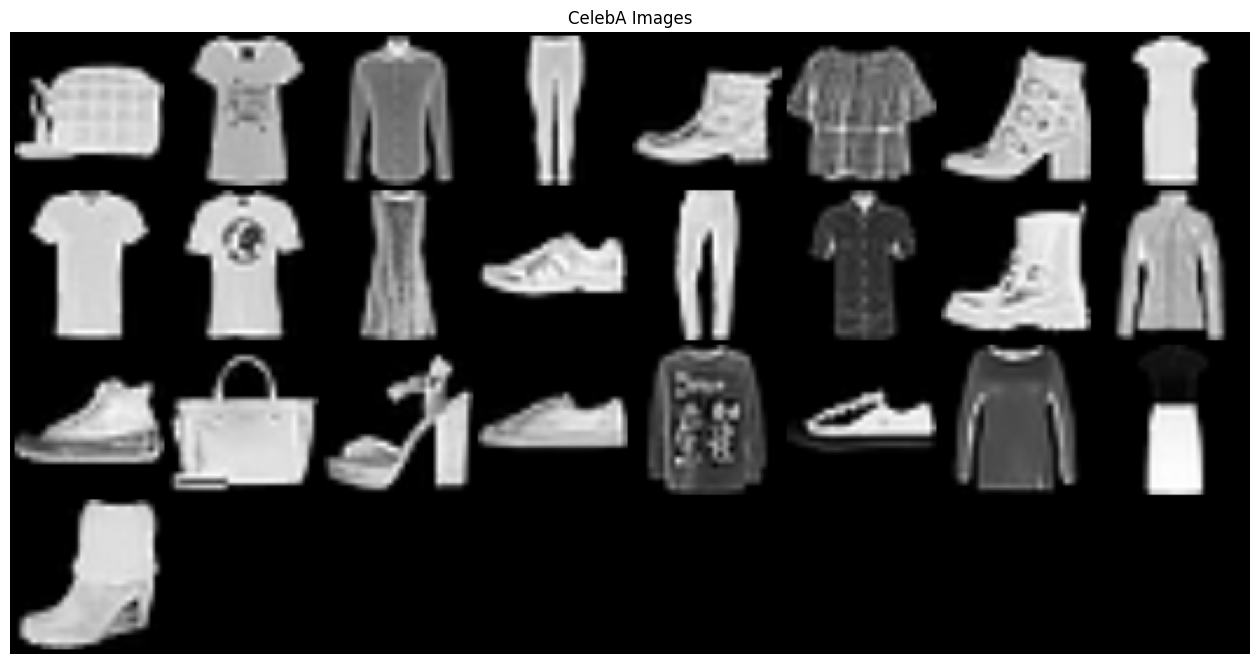

In [ ]:
import numpy as np

# Plot some training images
real_batch = next(iter(train_loader_mnist))
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("CelebA Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:25], padding=2, normalize=True),(1,2,0)))

# Prior
This cell performs an analysis to compute the average presence of each attribute in the Mnist-Fashion training dataset. This average will give the prior distribution p(y) of the data, that will be used by the CCVAE.


In [ ]:
total_images = 0
class_distribution = torch.zeros(10, 1)

for _, labels in train_loader_mnist:
    total_images += labels.size(0)
    for label in labels.numpy():
        class_distribution[label] += 1

# Calculate average distribution
mnist_prior = class_distribution / total_images
# Print the average distribution
print("Average Class Distribution:")
print(mnist_prior)

Average Class Distribution:
tensor([[0.1000],
        [0.1012],
        [0.1012],
        [0.0994],
        [0.1003],
        [0.0996],
        [0.1003],
        [0.0997],
        [0.0996],
        [0.0987]])


# Network

In next cell each of the components of the CCVAE will be defined:

*   Encoder: That predicts the distribution of z given x.
*   Decoder: That predicts x given z.
*   Classifier: That predicts the probabilities of the attributes y given z.
*   CondPrior: That predicts the distribution of z given the attributes y.



In [ ]:

# A utility class for reshaping tensors using the PyTorch nn.Module framework.
class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)

# A convolutional neural network encoder for the CCVAE.
class CELEBAEncoder(nn.Module):
    def __init__(self, z_dim, hidden_dim=256, *args, **kwargs):
        super().__init__()

        # Setup the convolutional layers
        self.z_dim = z_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(128, hidden_dim, 4, 1),
            nn.ReLU(True),
            View((-1, hidden_dim*1*1))
        )

        # Linear layer computing the mean of the distribution.
        self.locs = nn.Linear(hidden_dim, z_dim)

        # Linear layer computing the variance of the distribution.
        self.scales = nn.Linear(hidden_dim, z_dim)


    def forward(self, x):
        hidden = self.encoder(x)
        return self.locs(hidden), torch.clamp(F.softplus(self.scales(hidden)), min=1e-3)

# A convolutional neural network decoder for the CCVAE.
class CELEBADecoder(nn.Module):
    def __init__(self, z_dim, hidden_dim=256, *args, **kwargs):
        super().__init__()

        self.decoder = nn.Sequential(
            # Setup the
            nn.Linear(z_dim, hidden_dim),
            View((-1, hidden_dim, 1, 1)),

            # Setup the convolutional layers
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_dim, 128, 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.decoder(z)
        return x

# A module to implement a diagonal transformation.
class Diagonal(nn.Module):
    def __init__(self, dim):
        super(Diagonal, self).__init__()
        self.dim = dim
        self.weight = nn.Parameter(torch.ones(self.dim))
        self.bias = nn.Parameter(torch.zeros(self.dim))

    def forward(self, x):
        return x * self.weight + self.bias

# A simple classifier model implemented as a neural network
class Classifier(nn.Module):
    def __init__(self, dim):
        super(Classifier, self).__init__()
        self.dim = dim
        self.diag = Diagonal(self.dim)

    def forward(self, x):
        return self.diag(x)

# A model to compute conditional prior distributions.
class CondPrior(nn.Module):
    def __init__(self, dim):
        super(CondPrior, self).__init__()
        self.dim = dim
        self.diag_loc_true = nn.Parameter(torch.zeros(self.dim))
        self.diag_loc_false = nn.Parameter(torch.zeros(self.dim))
        self.diag_scale_true = nn.Parameter(torch.ones(self.dim))
        self.diag_scale_false = nn.Parameter(torch.ones(self.dim))

    def forward(self, x):
        loc = x * self.diag_loc_true + (1 - x) * self.diag_loc_false
        scale = x * self.diag_scale_true + (1 - x) * self.diag_scale_false
        return loc, torch.clamp(F.softplus(scale), min=1e-3)

The class CCVAE implemented in the next cell implements a Conditional Convolutional Variational Autoencoder (CCVAE).


In [ ]:

class CCVAE(nn.Module):
    def __init__(self, z_dim, num_classes, y_prior_params, use_cuda):
        super(CCVAE, self).__init__()
        self.encoder = CELEBAEncoder(z_dim)
        self.decoder = CELEBADecoder(z_dim)
        self.classifier=Classifier(num_classes)
        self.cond_prior = CondPrior(num_classes)
        self.y_prior_params = y_prior_params
        self.num_classes = num_classes
        self.z_dim = z_dim
        self.use_cuda = use_cuda
        self.ones = torch.ones(1, self.z_dim - self.num_classes)
        self.zeros = torch.zeros(1, self.z_dim - self.num_classes)

        if self.use_cuda:
            self.ones = self.ones.cuda()
            self.zeros = self.zeros.cuda()
            self.y_prior_params = self.y_prior_params.cuda()
            self.cuda()

    # Method to reconstruct an image by encoding and then decoding it.
    def reconstruct_img(self, x):
            return self.decoder(dist.Normal(*self.encoder(x)).rsample())

    # Method that computes the loss of the classifier module for a given x, y
    def classifier_loss(self, x, y, k=100):
        # Sample from the encoder
        zc, _ = dist.Normal(*self.encoder(x)).rsample(torch.tensor([k])).split([self.num_classes, self.z_dim - self.num_classes], -1)
        logits = self.classifier(zc.view(-1, self.num_classes))
        d = dist.Bernoulli(logits=logits)

        # Compute classifier loss
        y = y.expand(k, -1, -1).contiguous().view(-1, self.num_classes)
        lqy_z = d.log_prob(y).view(k, x.shape[0], self.num_classes).sum(dim=-1)
        lqy_x = torch.logsumexp(lqy_z, dim=0) - np.log(k)
        return lqy_x#.mean()

    # Calculate the log likelihood between an original and a reconstructed image
    def img_log_likelihood(self, recon, xs):
        # It returns the log likelihood between an image and its encoder-decoder
        # reconstruction.
        return dist.Laplace(recon, torch.ones_like(recon)).log_prob(xs).sum(dim=(1,2,3))

    # Compute the prior distribution for the attributes, p(y)
    def computer_prior_distribution(self, y, batch_size):
        return dist.Bernoulli(self.y_prior_params.expand(batch_size, -1)).log_prob(y).sum(dim=-1)

    # Compute the KL divergence for the given distributions.
    # In this case, it returns the KL distance between q(zc|x) and p(zc|y)
    def compute_kl(self, mean_q_zc, variance_q_zc, mean_p_zc, variance_p_zc):
        if mean_p_zc is None:
            mean_p_zc = torch.zeros_like(mean_q_zc)
        if variance_p_zc is None:
            variance_p_zc = torch.ones_like(variance_q_zc)

        dist_q = dist.Normal(mean_q_zc, variance_q_zc)
        dist_p = dist.Normal(mean_p_zc, variance_p_zc)
        return dist.kl.kl_divergence(dist_q, dist_p).sum(dim=-1)

    # Returns a partition of the latent space into characteristics and style components.
    def get_latent_space_partition(self, z):
        zc, zs = z.split([self.num_classes, self.z_dim - self.num_classes], 1)
        return zc, zs

    # Calculate the distribution q(y|zc)
    def computer_prior_given_latent_distribution(self, y, zc, propagate):
        if propagate:
            qyzc = dist.Bernoulli(logits=self.classifier(zc))
            return qyzc.log_prob(y).sum(dim=-1)
        else:
            return dist.Bernoulli(logits=self.classifier(zc.detach())).log_prob(y).sum(dim=-1)

    # Compute the overall loss function of the CCVAE
    def ccvae_loss_function(self, x, y):

        batch_size = x.shape[0]

        # Get the outputs of each submodel
        mean_q_z, variance_q_z = self.encoder(x)

        z = dist.Normal(mean_q_z, variance_q_z).rsample()
        zc, zs = self.get_latent_space_partition(z)

        recon = self.decoder(z)

        mean_p_zc, variance_p_zc = self.cond_prior(y)
        mean_p_zc = torch.cat([mean_p_zc, self.zeros.expand(batch_size, -1)], dim=1)
        variance_p_zc = torch.cat([variance_p_zc, self.ones.expand(batch_size, -1)], dim=1)

        # Get distributions
        log_py = self.computer_prior_distribution(y, batch_size)
        log_pxz = self.img_log_likelihood(recon, x)
        log_qyzc_propagate = self.computer_prior_given_latent_distribution(y, zc, True)
        log_qyzc_no_propagate_ = dist.Bernoulli(logits=self.classifier(zc.detach())).log_prob(y).sum(dim=-1)
        log_qyx = self.classifier_loss(x, y)

        # Compute KL
        dkl = self.compute_kl(mean_q_z, variance_q_z, mean_p_zc, variance_p_zc)

        # Compute elbo
        elbo = (torch.exp(log_qyzc_no_propagate_ - log_qyx) * (log_pxz - dkl - log_qyzc_propagate) + log_py + log_qyx).mean()

        return -elbo

    # Method to calculate the classification accuracy of the model for the given x,y
    def classifier_acc(self, x, y=None, k=1):
        # Sample the latent space and split into characteristic and style components
        zc, _ = dist.Normal(*self.encoder(x)).rsample(torch.tensor([k])).split([self.num_classes, self.z_dim - self.num_classes], -1)

        # Predict by applying sigmoid and rounding, then compare with true labels
        logits = self.classifier(zc.view(-1, self.num_classes)).view(-1, self.num_classes)
        y = y.expand(k, -1, -1).contiguous().view(-1, self.num_classes)
        preds = torch.round(torch.sigmoid(logits))

        # Compute accuracy
        acc = (preds.eq(y)).float().mean()
        return acc


# Train the Model

Let's define a function to plot the reconstruction of an image using the encoder and the decoder of a CCVAE.

In [ ]:
## Plot the reconstructed image during training
def plot_image_recon(image, model):
  recon = model.reconstruct_img(image.cuda()).cpu().squeeze()
  recon = recon.permute(1,0)
  with torch.no_grad():
    plt.figure(figsize=(1,1))
    plt.imshow(recon)
    plt.show()
def one_hot_encode(labels, num_classes):
    return F.one_hot(labels, num_classes)

Define the parameters of the training.

In [ ]:
num_classes = 10  # Fashion MNIST has 10 classes
img_shape = (1, 64, 64)
cc_vae = CCVAE(45, num_classes, mnist_prior, True) #CCVAE Model
optim = torch.optim.Adam(cc_vae.parameters(), lr = 0.002) #Adam optimizer

Next cell executes the training loop. Inside the loop there is a tracking of the performance across epochs, and the different checkpoints of the model will be saved.

<ipython-input-318-2d58816e45da>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ys = torch.tensor(one_hot_encode(ys, num_classes)).clone().detach()
<ipython-input-318-2d58816e45da>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ys = torch.tensor(one_hot_encode(ys, num_classes))


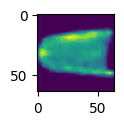

Epoch 0, Loss: 4755864.296386719, train accuracy: 0.9817437529563904, Val accuracy: 0.9799668788909912


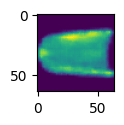

Epoch 1, Loss: 4748244.768310547, train accuracy: 0.9817031025886536, Val accuracy: 0.979699969291687


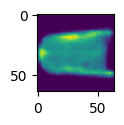

Epoch 2, Loss: 4758153.574951172, train accuracy: 0.981555163860321, Val accuracy: 0.9800835847854614


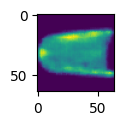

Epoch 3, Loss: 4758058.76953125, train accuracy: 0.9816482067108154, Val accuracy: 0.9799920916557312


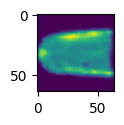

Epoch 4, Loss: 4763698.337646484, train accuracy: 0.9815680980682373, Val accuracy: 0.9800833463668823


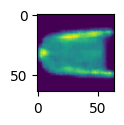

Epoch 5, Loss: 4758396.5498046875, train accuracy: 0.9816627502441406, Val accuracy: 0.9798002243041992


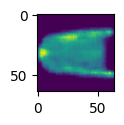

Epoch 6, Loss: 4748204.853027344, train accuracy: 0.9816426634788513, Val accuracy: 0.9800422191619873


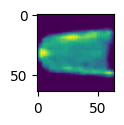

Epoch 7, Loss: 4748033.896484375, train accuracy: 0.9816535711288452, Val accuracy: 0.9799498319625854


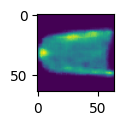

Epoch 8, Loss: 4750062.635009766, train accuracy: 0.9817514419555664, Val accuracy: 0.9799085855484009


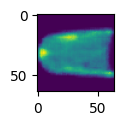

Epoch 9, Loss: 4746176.494140625, train accuracy: 0.9815965294837952, Val accuracy: 0.9798420071601868
[3170.576197591146, 3165.496512207031, 3172.102383300781, 3172.0391796875, 3175.798891764323, 3172.2643665364585, 3165.4699020182293, 3165.355930989583, 3166.7084233398436, 3164.117662760417]


In [ ]:
best_accuracy = 0  # Initialize the best accuracy
# Define the path where checkpoints will be saved
path_to_save = './final_experiment_Mnist_Fashion'
os.makedirs(path_to_save, exist_ok=True)
number_epoch=10
train_losses=[]
train_acc=[]
val_acc=[]

for epoch in range(number_epoch):
    epoch_losses_sup = 0
    train_accuracy = 0.0
    for batch_idx, (xs, ys) in enumerate(train_loader_mnist):
      #ys = torch.tensor(one_hot_encode(ys, num_classes))
      ys = torch.tensor(one_hot_encode(ys, num_classes)).clone().detach()
      cc_vae.train()
      xs = xs.float().cuda()
      ys = ys.float().cuda()
      loss = cc_vae.ccvae_loss_function(xs, ys)
      epoch_losses_sup += loss.detach().item()
      loss.backward()
      optim.step()
      optim.zero_grad()
      batch_acc = cc_vae.classifier_acc(xs, ys)
      train_accuracy += batch_acc

    train_accuracy = train_accuracy / len(train_loader_mnist)
    train_loss=epoch_losses_sup/len(train_loader_mnist)
    train_acc.append(train_accuracy)
    train_losses.append(train_loss)
    cc_vae.eval()
    validation_accuracy = 0.0
    for batch_idx, (xs, ys) in enumerate(val_loader_mnist):
      ys = torch.tensor(one_hot_encode(ys, num_classes))
      xs = xs.float().cuda()
      ys = ys.float().cuda()
      batch_acc = cc_vae.classifier_acc(xs, ys)
      validation_accuracy += batch_acc
    validation_accuracy = validation_accuracy / len(val_loader_mnist)
    val_acc.append(validation_accuracy)
    with torch.no_grad():
        plot_image_recon(example, cc_vae)
    # Print the epoch loss
    print(f"Epoch {epoch}, Loss: {epoch_losses_sup}, train accuracy: {train_accuracy}, Val accuracy: {validation_accuracy}")
    #Save checkpoint after every epoch
    torch.save(cc_vae.state_dict(), os.path.join(path_to_save, f'checkpoint_epoch_{epoch}.pt'))
    # Check if this is the best accuracy so far and save if it is
    if validation_accuracy > best_accuracy:
        best_accuracy = validation_accuracy
        torch.save(cc_vae.state_dict(), os.path.join(path_to_save, 'best_accuracy_checkpoint.pt'))

print(train_losses)

# Analyze training results

In [ ]:
train_acc_cpu = []
train_losses_cpu = []
val_losses_cpu=[]
for acc in train_acc:
    train_acc_cpu.append(acc.cpu())

for loss in train_losses:
    train_losses_cpu.append(loss.cpu())

for loss in val_acc:
    val_losses_cpu.append(loss.cpu())



This cell visualizes the training and validation metrics over the course of training epochs.


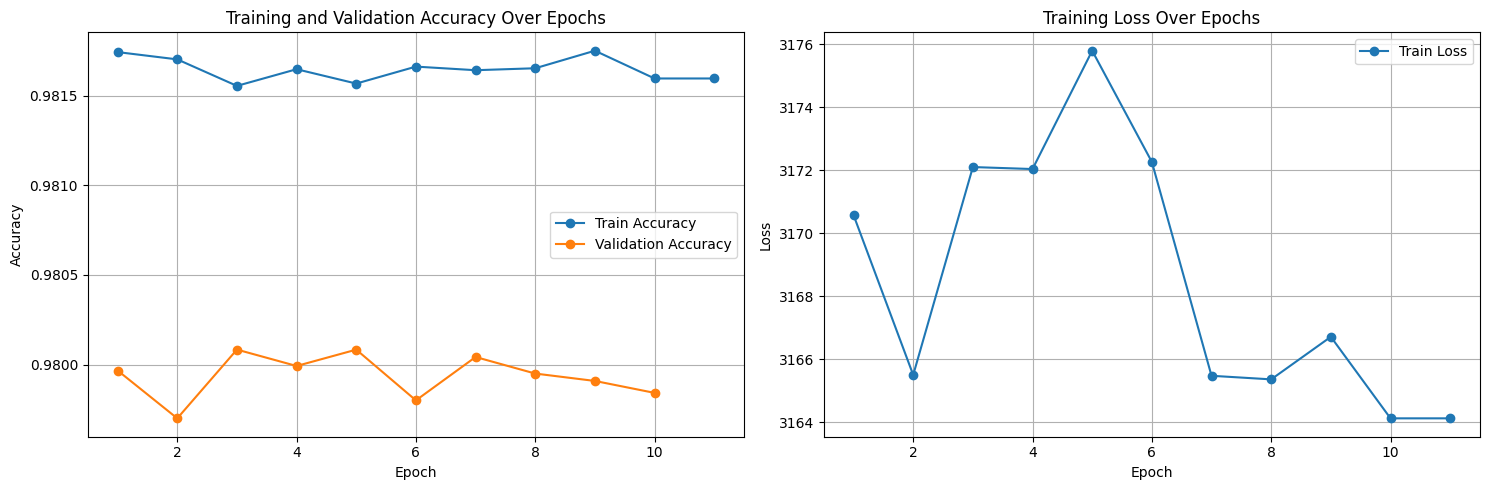

In [ ]:
#Plotting
number_epoch=11
import matplotlib.pyplot as plt
epochs = list(range(1, number_epoch+1))
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plotting accuracy
axs[0].plot(epochs, train_acc_cpu, label='Train Accuracy', marker='o')
epochs = list(range(1, number_epoch))
axs[0].plot(epochs, val_losses_cpu, label='Validation Accuracy', marker='o')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy Over Epochs')
axs[0].legend()
axs[0].grid(True)

# Plotting loss
epochs = list(range(1, number_epoch+1))
axs[1].plot(epochs, train_losses_cpu, label='Train Loss', marker='o')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training Loss Over Epochs')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Experiments

Next cell will load the model with the best validation accuracy.

In [ ]:
cc_vae = CCVAE(45, 10, mnist_prior, True)
checkpoint_path = "/content/final_experiment_Mnist_Fashion/best_accuracy_checkpoint.pt"
checkpoint = torch.load(checkpoint_path)
cc_vae.load_state_dict(checkpoint)
cc_vae.eval()

CCVAE(
  (encoder): CELEBAEncoder(
    (encoder): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
      (9): ReLU(inplace=True)
      (10): View()
    )
    (locs): Linear(in_features=256, out_features=45, bias=True)
    (scales): Linear(in_features=256, out_features=45, bias=True)
  )
  (decoder): CELEBADecoder(
    (decoder): Sequential(
      (0): Linear(in_features=45, out_features=256, bias=True)
      (1): View()
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
      (4): ReLU(inpl

This function, `latent_walk_single_axis`, performs a latent space exploration along a single attribute axis for each class in the CelebA dataset. It visually demonstrates how changes in the latent space affect generated facial attributes.




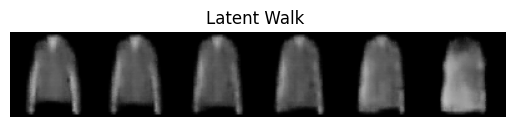

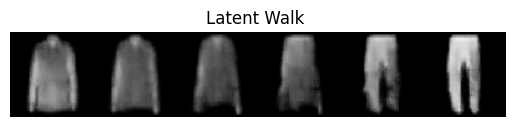

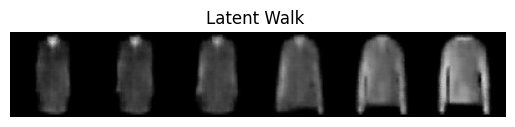

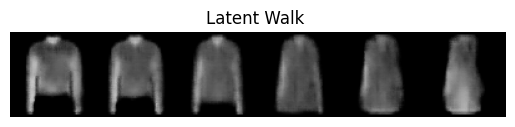

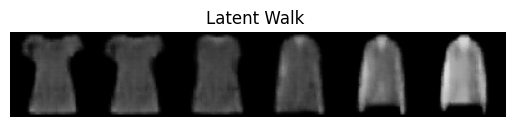

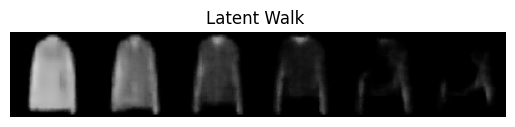

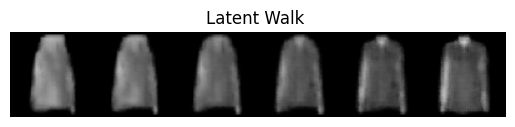

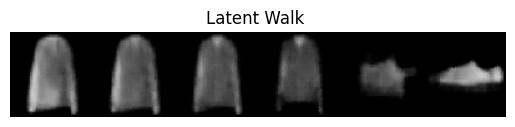

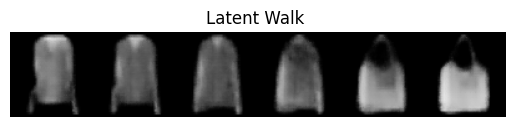

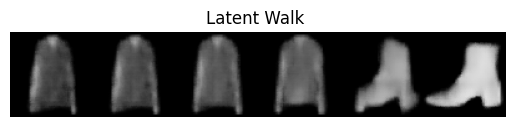

In [ ]:
img_shape = (1, 64, 64)

def latent_walk_single_axis(num_classes, im_shape, image, save_dir, model, num_steps=6, display_grid=True):
    device = next(model.parameters()).device
    mult = 5

    # Ensure the image is on the same device as the model
    image = image.to(device)

    # Sample from the latent space
    z_ = dist.Normal(*model.encoder(image.unsqueeze(0))).sample()[0]

    for i in range(num_classes):
        y = torch.zeros(1, num_classes).to(device)
        locs_false, scales_false = model.cond_prior(y)
        y[:, i].fill_(1.0)
        locs_true, scales_true = model.cond_prior(y)
        sign = torch.sign(locs_true[:, i] - locs_false[:, i])

        z_false_lim = (locs_false[:, i] - mult * sign * scales_false[:, i]).item()
        z_true_lim = (locs_true[:, i] + mult * sign * scales_true[:, i]).item()

        # Construct the range for the latent variable
        z_range = torch.linspace(z_false_lim, z_true_lim, num_steps)

        # Generate images for each step in the latent space
        imgs = []
        for z_val in z_range:
            z = z_.clone()
            z[i] = z_val
            img = model.decoder(z.unsqueeze(0)).view(*im_shape)
            imgs.append(img)

        # Create a grid of images
        grid = make_grid(imgs, nrow=num_steps)
        #save_image(grid, os.path.join(save_dir, f"latent_walk_{CELEBA_EASY_LABELS[i]}.png"))

        # Display the grid
        if display_grid:
            plt.imshow(to_pil_image(grid))
            plt.title(f"Latent Walk ")
            plt.axis('off')
            plt.show()

# Usage example:
# latent_walk_single_axis(num_classes, im_shape, image, save_dir, model)
num_classes = 10
img_shape = (1, 64, 64)  # Define the shape of the image
save_dir = "/content/final_experiment2"
latent_walk_single_axis(num_classes, img_shape, example, save_dir, cc_vae)